In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import cache_magic
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go

from tracking_v2.target import NearConstantVelocityTarget
from tracking_v2.kalman import LinearKalmanFilter, GatedFilter
from tracking_v2.motion import ConstantVelocityModel
from tracking_v2.sensor import GeometricSensor
from tracking_v2.evaluation import StateFilterRunner, evaluate_runner, plot_nscore, plot_runs, plot_2d, plot_track
import tracking_v2.evaluation.runner as runner

from tracking_v2.util import to_df, display
import IPython.display as ipython

In [4]:
display.as_png = True

In [5]:
class GatedRunner(StateFilterRunner):
    @runner.after_update
    def collect_meas_noise(self, m):
        self.one_noise.append(m.error)

    @runner.before_many
    def prepare_trace(self):
        self.many_gates = []
        self.many_noise = []
        
    @runner.before_one
    def prepare_one_noise(self):
        self.one_noise = []
    
    @runner.after_one
    def collect_run(self):
        if hasattr(self.kf, 'gates'):
            self.many_gates.append(np.asarray(self.kf.gates))
        self.many_noise.append(np.asarray(self.one_noise))
    
    @runner.after_many
    def finalize_trace(self):
        self.many_gates = np.asarray(self.many_gates)
        self.many_noise = np.asarray(self.many_noise)
    
def _cv(q):
    motion = ConstantVelocityModel(q)
    return LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                       [0, 1, 0, 0, 0, 0],
                                       [0, 0, 1, 0, 0, 0]])

def _gated_cv(q, max_chi_sq):
    return GatedFilter(_cv(q), max_chi_sq)

def _run_cv(kf, noise_intensity, m=100, n=500, T=1, seeds=None):
    target = NearConstantVelocityTarget(noise_intensity=noise_intensity)
    sensor = GeometricSensor()
    
    r = GatedRunner(target, sensor, kf)
    r.run_many(m, n, T, seeds=seeds)
    return r

In [6]:
r1 = _run_cv(_cv(1), 1)
e1 = evaluate_runner(r1)

In [7]:
gate = sp.stats.chi2.ppf(0.99, 3)
print(gate)

kf = _gated_cv(1, gate)
r2 = _run_cv(kf, 1)
e2 = evaluate_runner(r2)

11.344866730144373


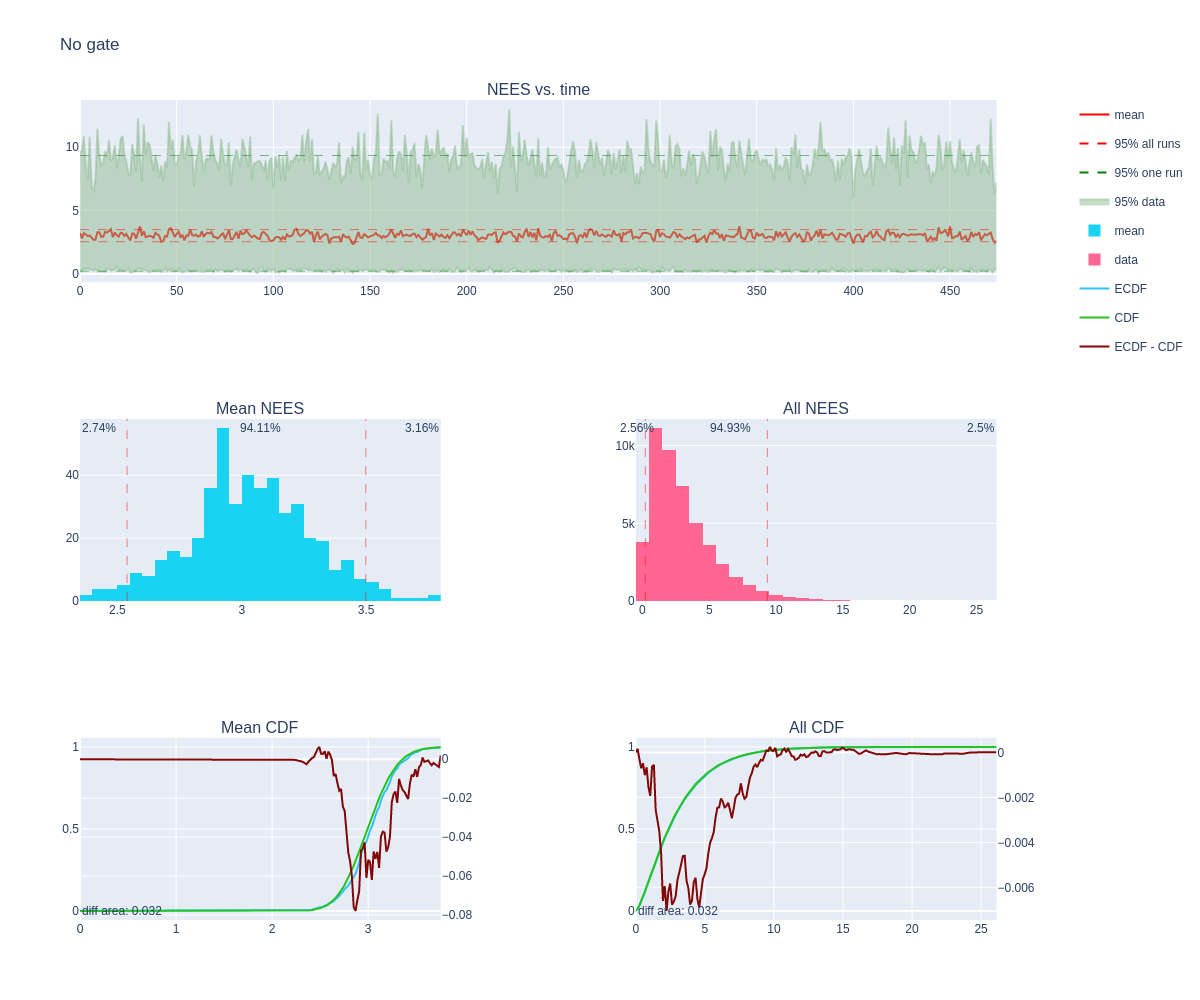

In [8]:
display(plot_nscore(e1.position_nees, title='No gate'), height=1000)

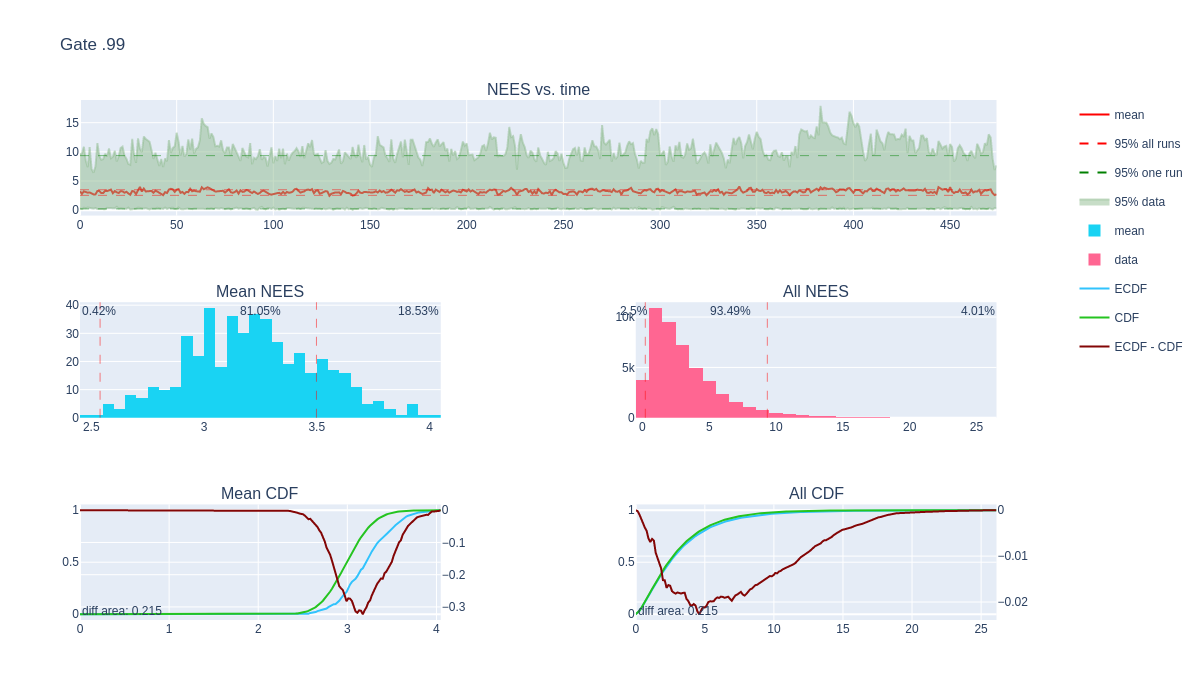

In [9]:
display(plot_nscore(e2.position_nees, title='Gate .99'))

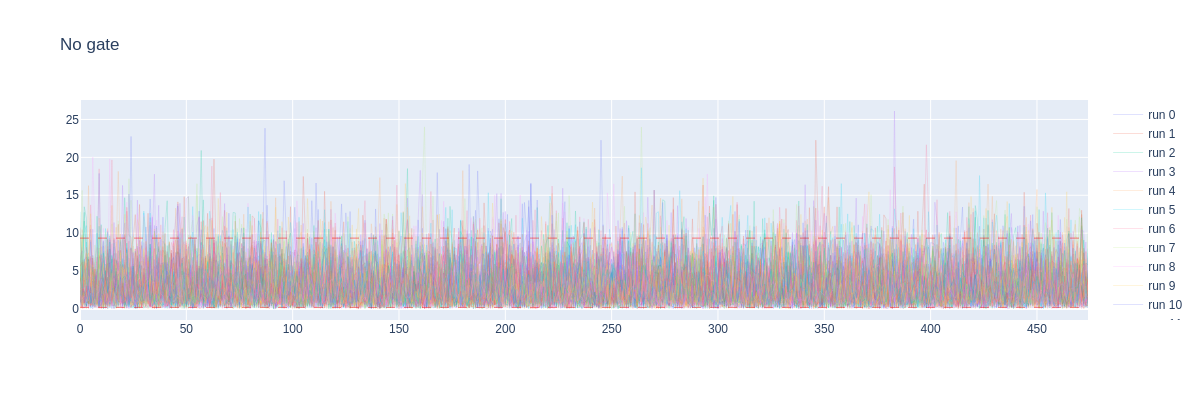

In [10]:
display(plot_runs(e1.position_nees, title='No gate'), height=400)

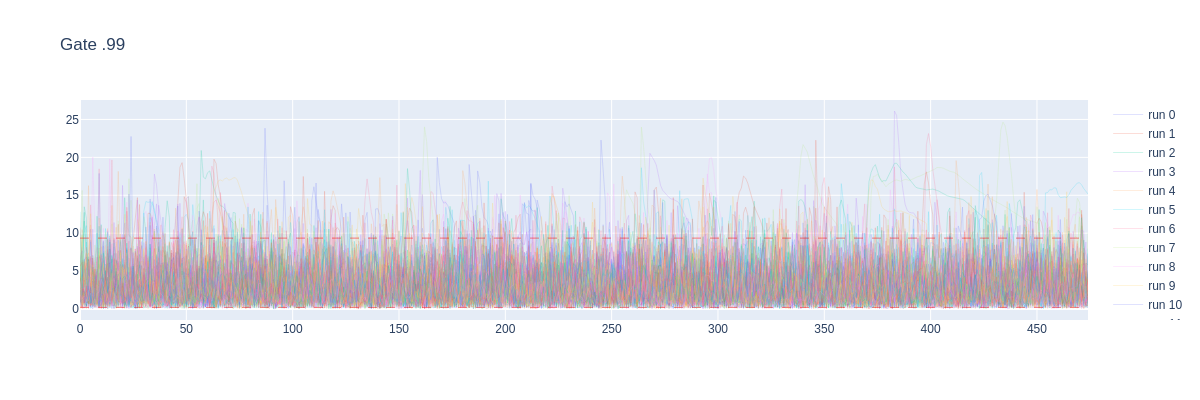

In [11]:
display(plot_runs(e2.position_nees, title='Gate .99'), height=400)

In [12]:
gate = sp.stats.chi2.ppf(0.975, 3)
print(gate)

kf = _gated_cv(1, gate)
r3 = _run_cv(kf, 1)
e3 = evaluate_runner(r3)

9.348403604496148


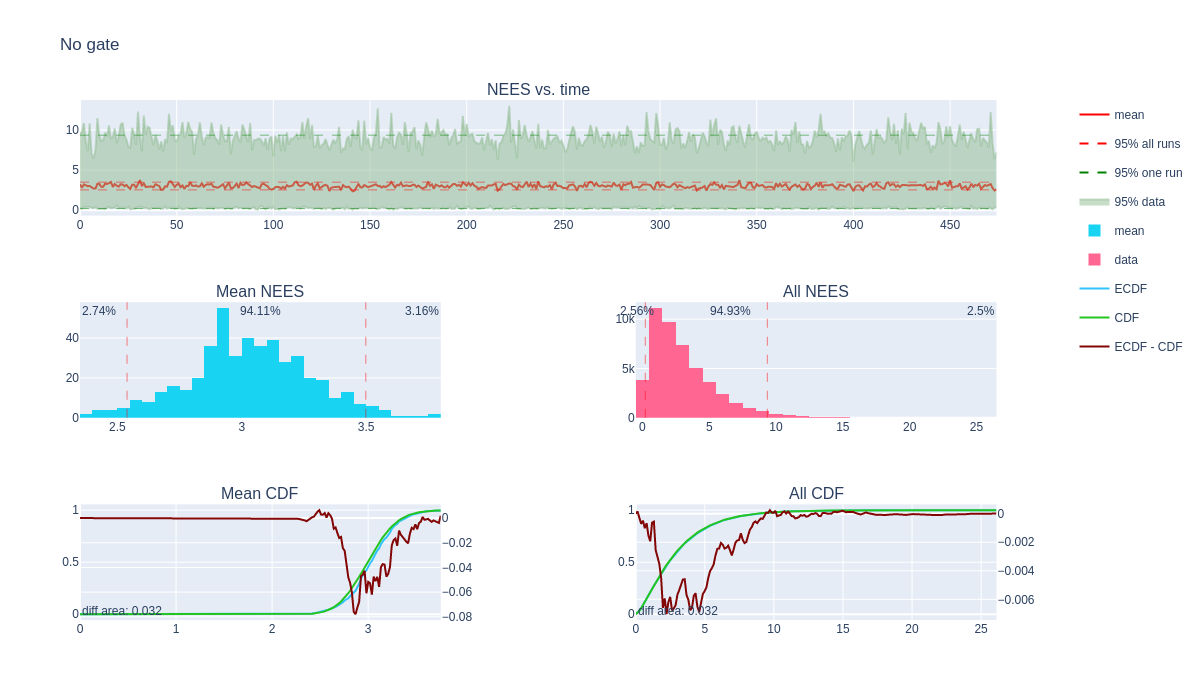

In [13]:
display(plot_nscore(e1.position_nees, title='No gate'))

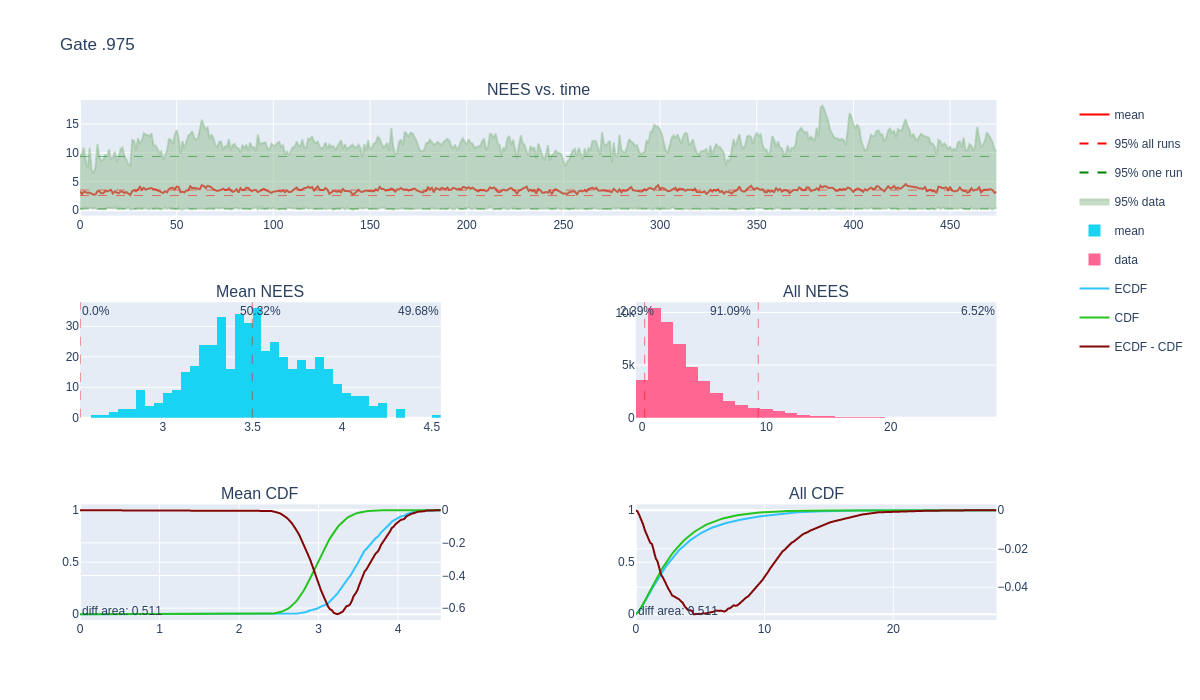

In [14]:
display(plot_nscore(e3.position_nees, title='Gate .975'))

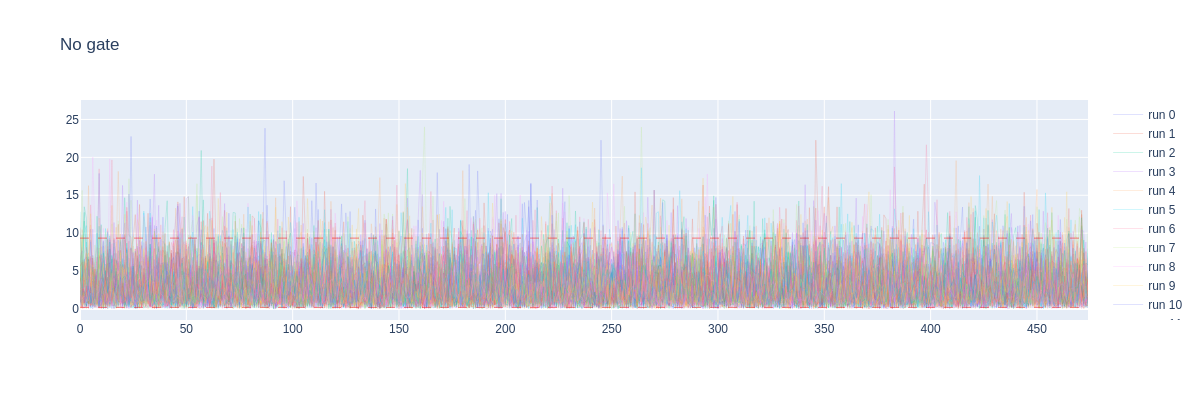

In [15]:
display(plot_runs(e1.position_nees, title='No gate'), height=400)

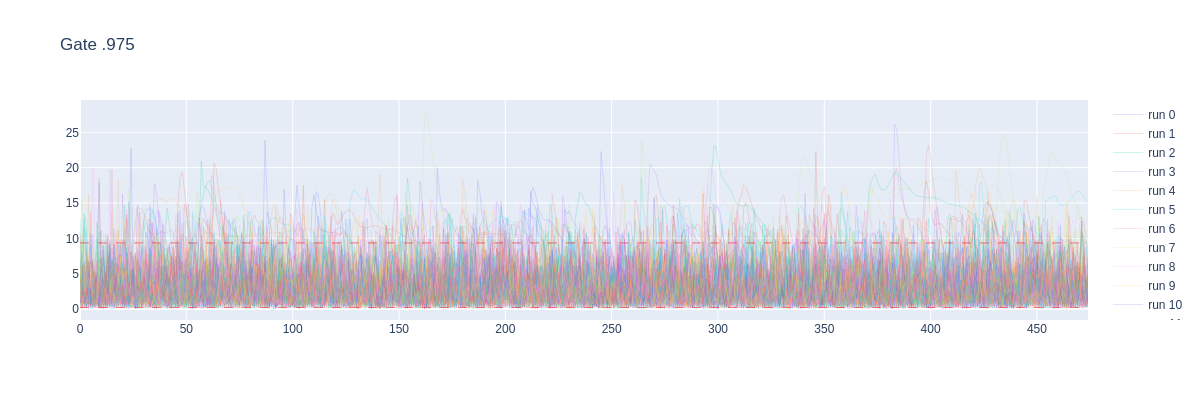

In [16]:
display(plot_runs(e3.position_nees, title='Gate .975'), height=400)

In [17]:
gate = sp.stats.chi2.ppf(0.95, 3)
print(gate)

kf = _gated_cv(1, gate)
r4 = _run_cv(kf, 1)
e4 = evaluate_runner(r4)

7.814727903251179


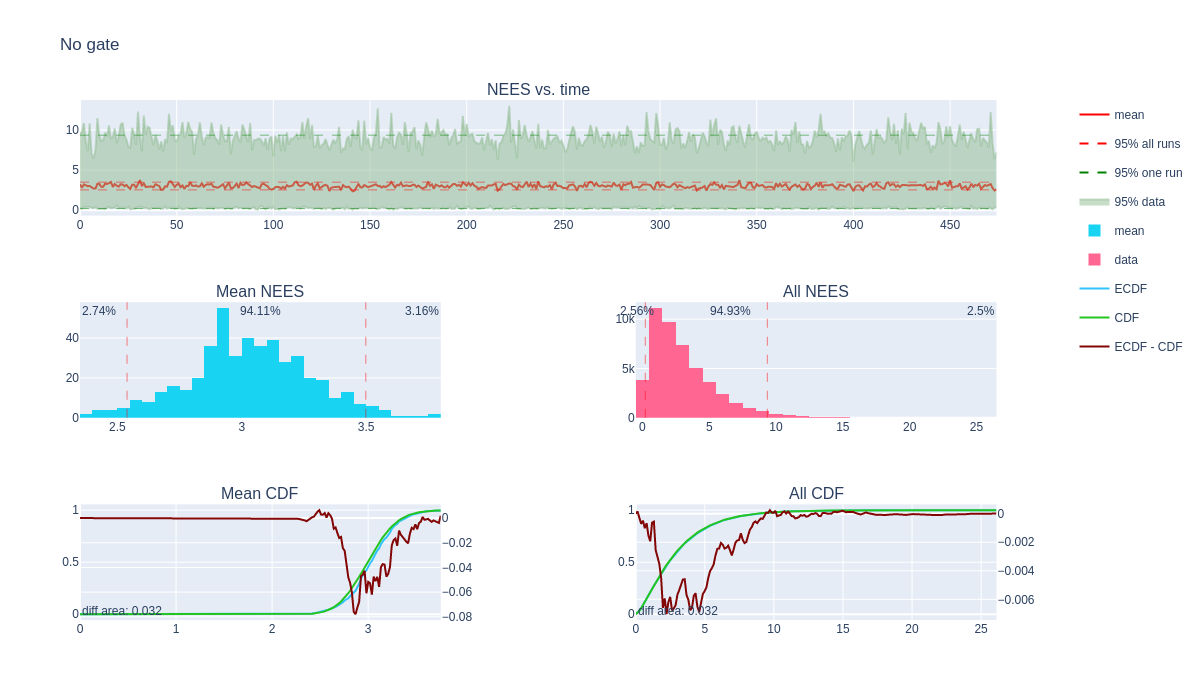

In [18]:
display(plot_nscore(e1.position_nees, title='No gate'))

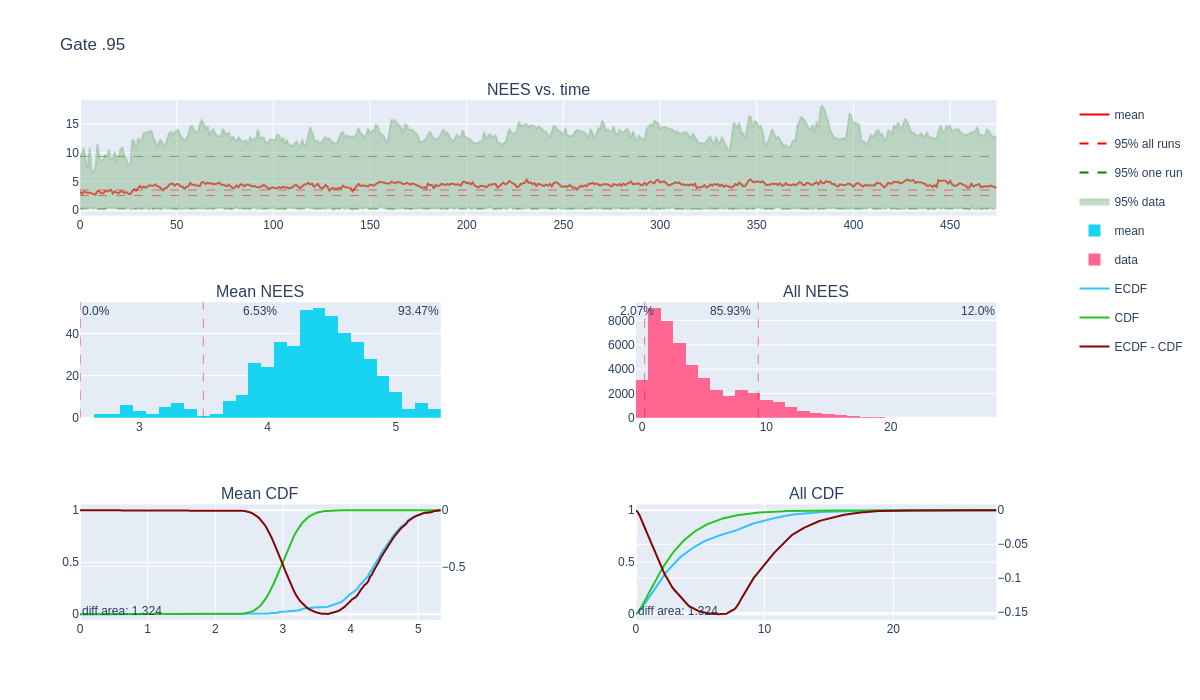

In [19]:
display(plot_nscore(e4.position_nees, title='Gate .95'))

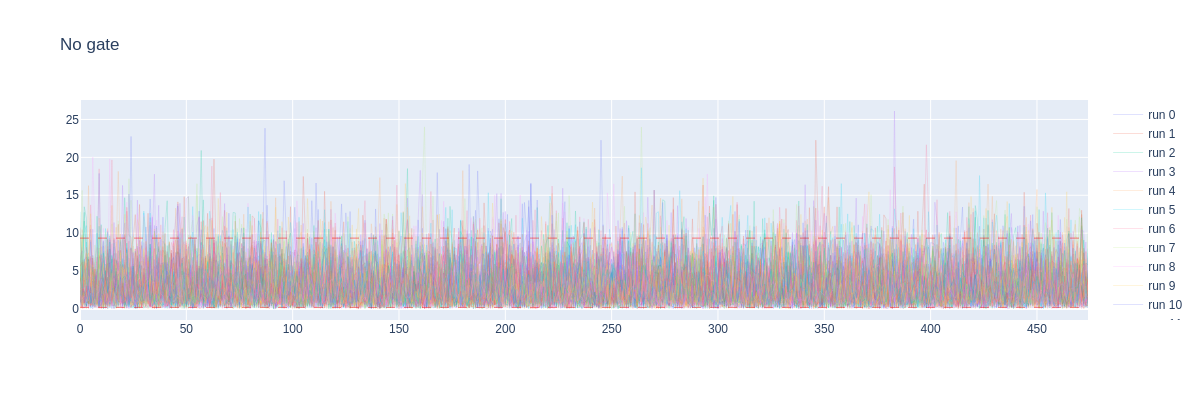

In [20]:
display(plot_runs(e1.position_nees, title='No gate'), height=400)

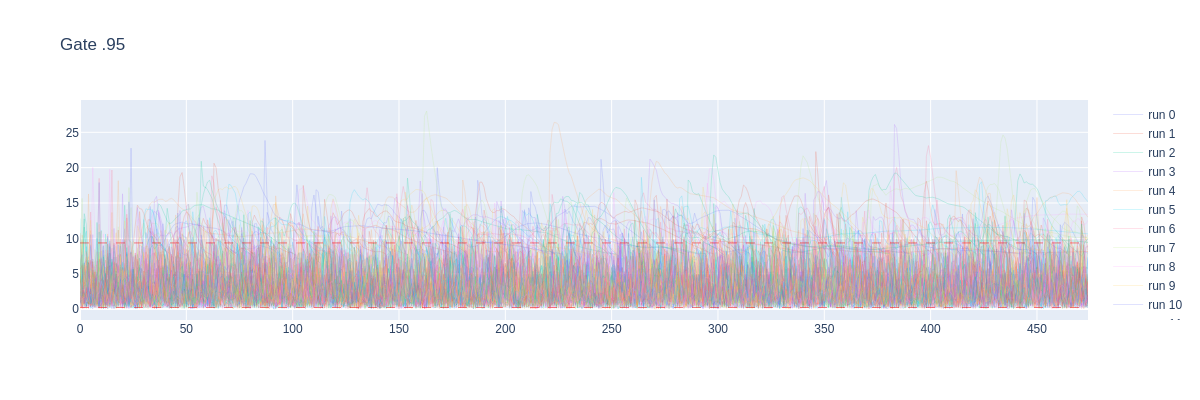

In [21]:
display(plot_runs(e4.position_nees, title='Gate .95'), height=400)

In [22]:
rT = _run_cv(_cv(1), 1, T=5)
eT = evaluate_runner(rT)

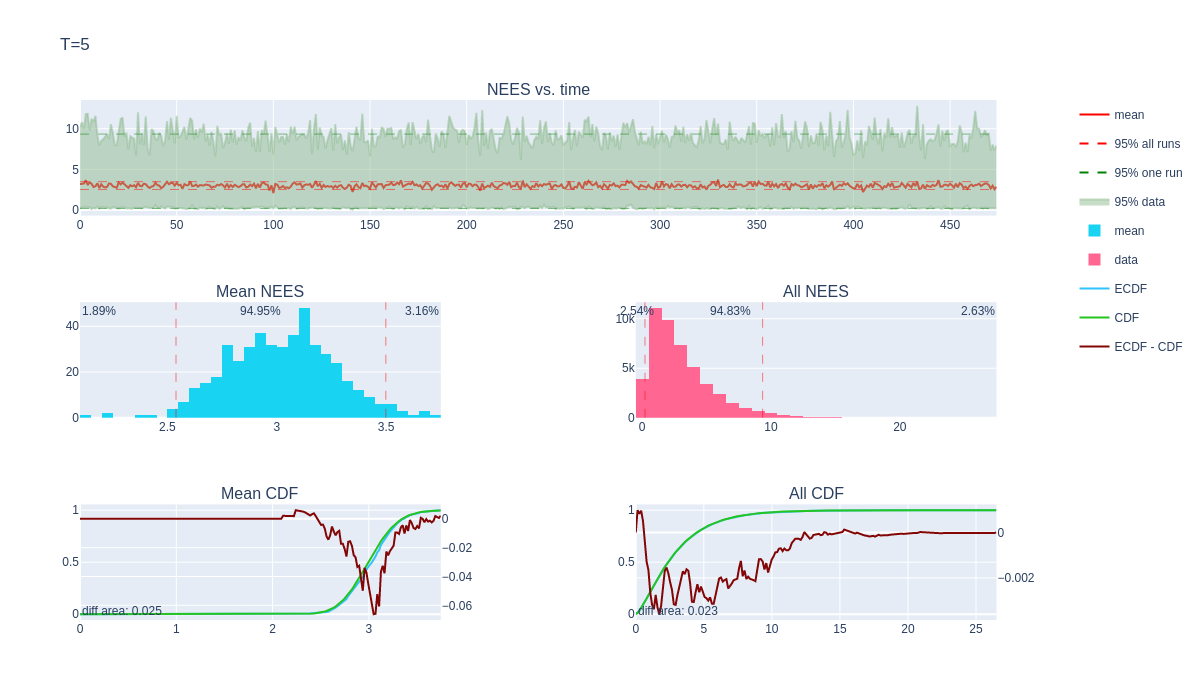

In [23]:
display(plot_nscore(eT.position_nees, title='T=5'))

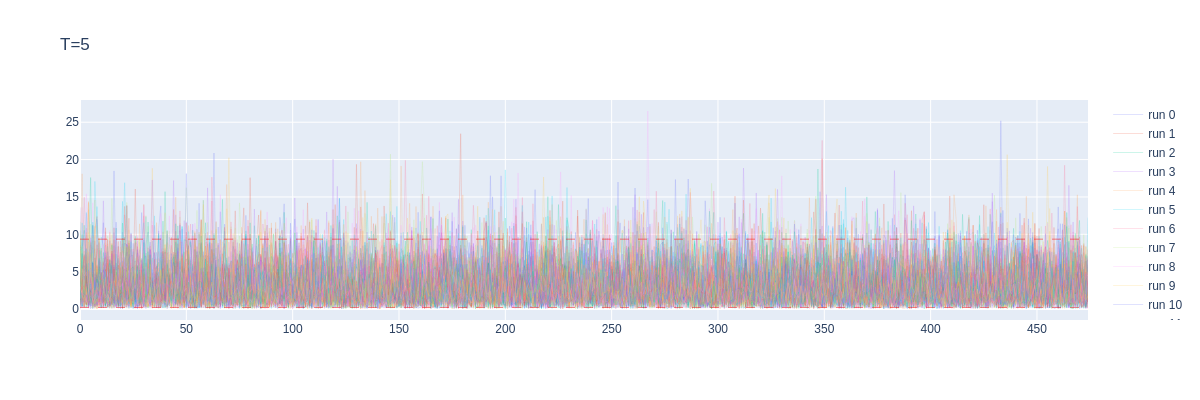

In [24]:
display(plot_runs(eT.position_nees, title='T=5'), height=400)

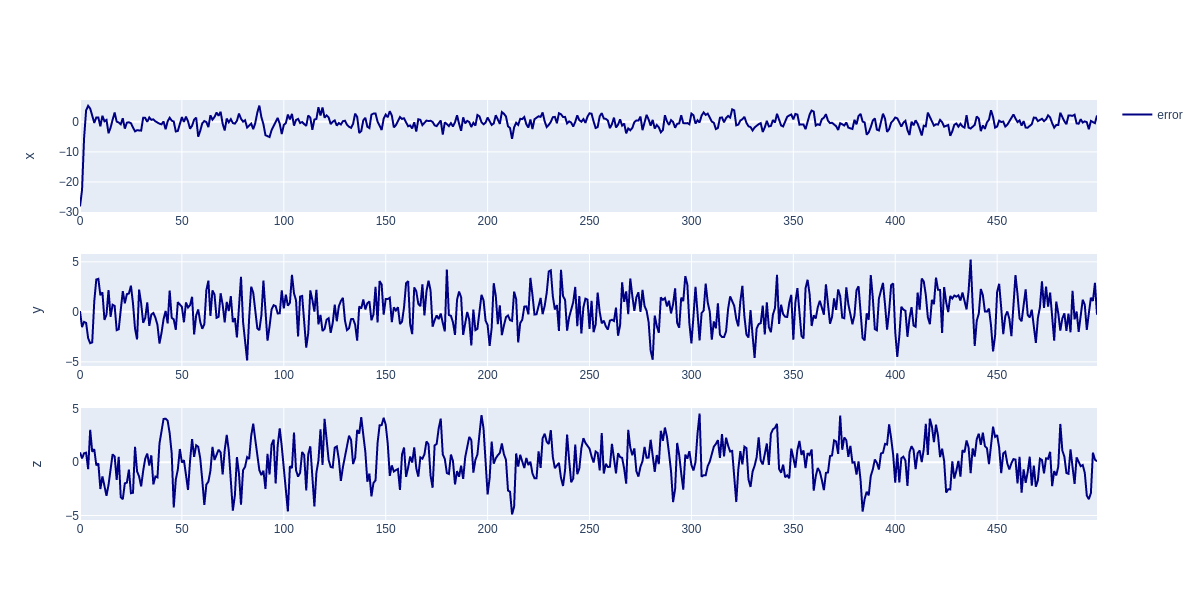

In [25]:
display(plot_2d(r1, residual=True), height=600)

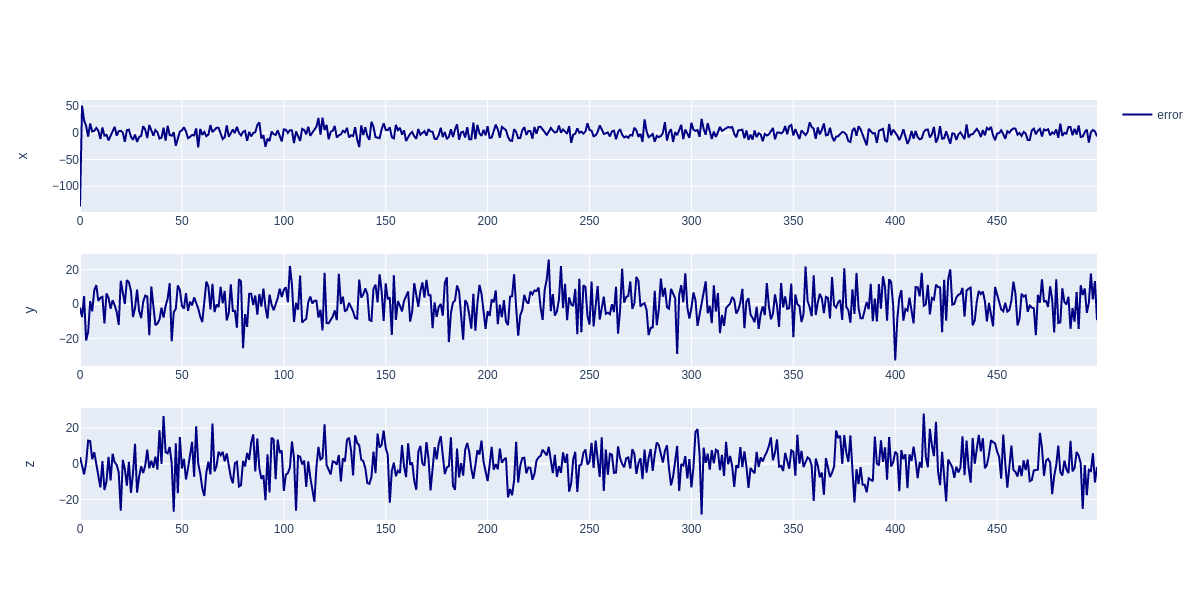

In [26]:
display(plot_2d(rT, residual=True), height=600)

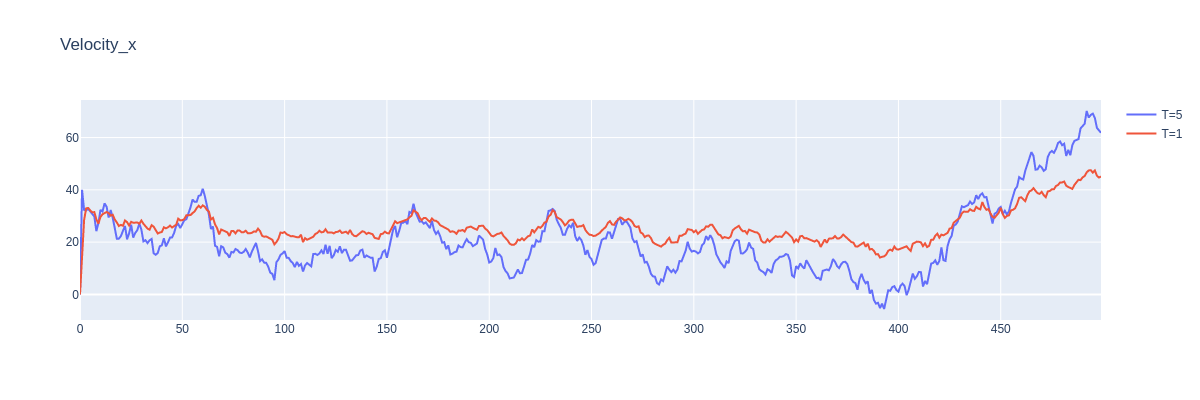

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=rT.one_x_hat[:,3,0], name='T=5'))
fig.add_trace(go.Scatter(y=r1.one_x_hat[:,3,0], name='T=1'))
fig.update_layout(title='Velocity_x')
display(fig, height=400)

# Investigate imapct of the gate

When an observation is rejected, often a number of succeeding observations are also rejected. Why?

In [28]:
seeds = [2]

r1 = _run_cv(_cv(1), 1, m=1, seeds=seeds)

gate = sp.stats.chi2.ppf(0.99, 3)
print(gate)
r2 = _run_cv(_gated_cv(1, gate), 1, m=1, seeds=seeds)

e1 = evaluate_runner(r1)
e2 = evaluate_runner(r2)

11.344866730144373


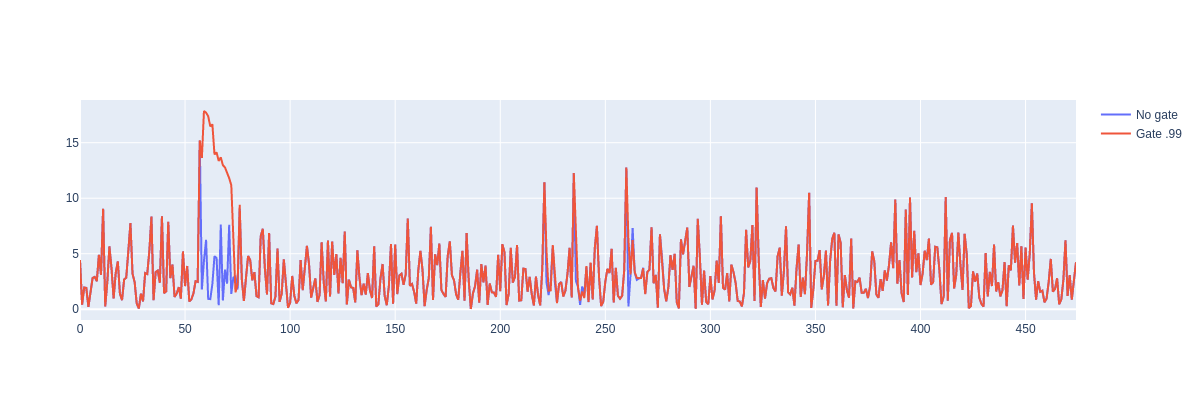

In [29]:
fig = go.Figure()

scores = e1.position_nis.scores[0, 25:]
fig.add_trace(go.Scatter(x=np.arange(len(scores)), y=scores, name='No gate'))

scores = e2.position_nis.scores[0, 25:]
fig.add_trace(go.Scatter(x=np.arange(len(scores)), y=scores, name='Gate .99'))

display(fig, height=400)

When a gate is used, and a measurement with a large error is made, that measurement is rejected due to large NIS. This causes the estimated trajectory (estimates of position and velocity over time) to diverge from the target trajectory: the direction estimated from the last accepted measurement is extrapolated for a few iterations, until the estimated covariance is large enough to "swallow" the measurement. When that happens, and the measurement error puts the measurement close enough to the track, its NIS is once again below the gate threshold and the track "picks up" subsequent measurements once again.

Above, we see how the "Gate .99" NIS plot remains elevated above the "No gate" plot between `T=82` and `T=96`. We can investigate this dynamic in the animated plot below.

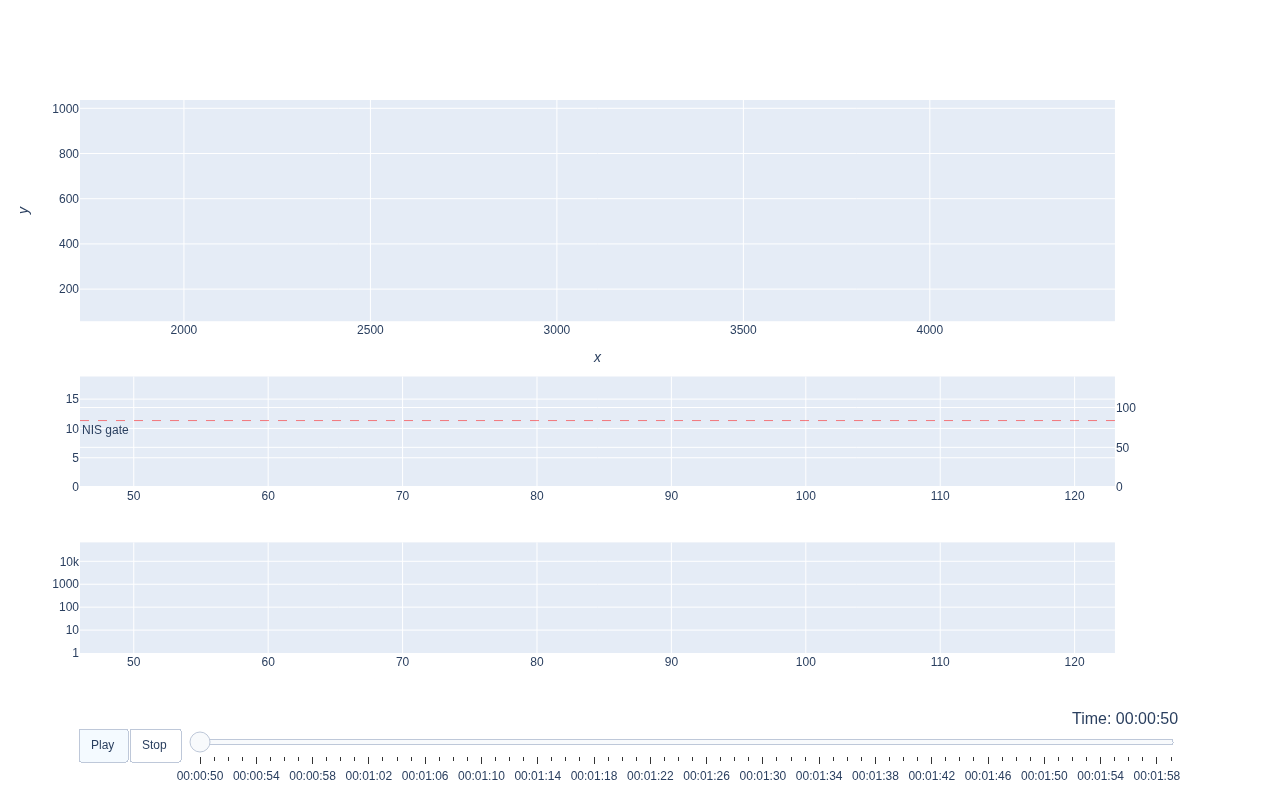

In [30]:
plot_track(r2, 0, slice(50, 120), gate=gate)

Here, we can look at individual numerical inputs which tell the same story.

In [31]:
run = 0
start = 70
stop  = 105

x = np.vstack((np.arange(start, stop),
                 np.sqrt(np.sum(np.power(r2.many_x_hat[run,start:stop,:3,0] - r2.many_z[run,(start+1):(stop+1),:3,0], 2), axis=1)),
                 r2.many_gates[run,start:stop,0],
                 r2.many_gates[run,start:stop,1],
                 e2.position_nis.scores[run,start:stop],
                 np.sqrt(np.sum(np.power(r2.many_noise[run,start:stop,:,:], 2), axis=2)).squeeze(),
                 np.sqrt(np.sum(np.power(r1.many_x_hat[run,start:stop,:3,0] - r1.many_z[run,(start+1):(stop+1),:3,0], 2), axis=1)),
                 e1.position_nis.scores[run,start:stop]
                )).T

with pd.option_context('display.max_rows', None):
    df = to_df(x, columns=['time', 'r2_z_err', 'r2_gate', 'r2_update', 'r2_nis', 'noise', 'r1_z_err', 'r1_nis'])

    def highlight_rows(row):
        if row['r2_update'] < 1:
            return ['background-color: #9ba329'] * len(row)
        return [''] * len(row)

    df = df.style.apply(highlight_rows, axis=1)
    ipython.display(df)